In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

**Preparing Data**

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #dataset download
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True) #datasetからflower image file download
#2011年時点にて3000以上の画像がflower_photosには入ってる
#As of my knowledge cutoff in September 2021, the "flower_photos" dataset from TensorFlow contained approximately 3670 images
#distributed among five types of flowers: daisy, dandelion, roses, sunflowers, and tulips.

# convert the path to a pathlib.Path object
data_dir = pathlib.Path(data_dir)
#これにより、a pathlib.Path objectという特別なobjectに出来る
#そしたらglob()methodなどが使えるようになる

228813984/228813984 [==============================] - 11s 0us/step


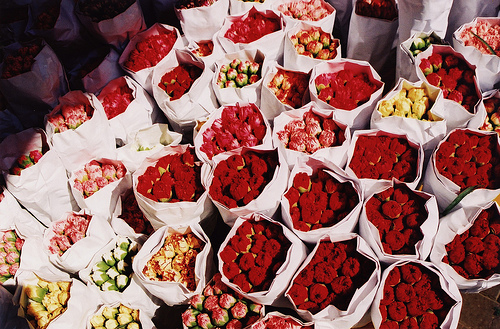

In [ ]:
###check one of the image files we obtained###
roses = list(data_dir.glob(str('roses/*')))
#creating a list of all files (in this case, image files) in the "roses" subdirectory of the main data directory (data_dir).
PIL.Image.open(roses[0])
#roses[0] using PIL(Python Image Library)

In [ ]:
#training用dataとvalidation用dataを確保
img_height,img_width=180,180
batch_size=32

#training用dataをtrain_dsにぶち込む
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #80% data for training and 20% data for validation #testingもあるけど100%を一気に3つにはsplitしない
  #20% for validationとすることにより、自動的に残り20%はtrainingにdistributed
  subset="training",
  #80% data for training and 20% data for validationというのは決まったけど
  #今回train_dsにtraining subsetをぶち込む or validation subsetをぶち込むかを指定
  seed=123, #乱数
  image_size=(img_height, img_width),
  batch_size=batch_size)

#validation用dataをval_dsにぶち込む
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


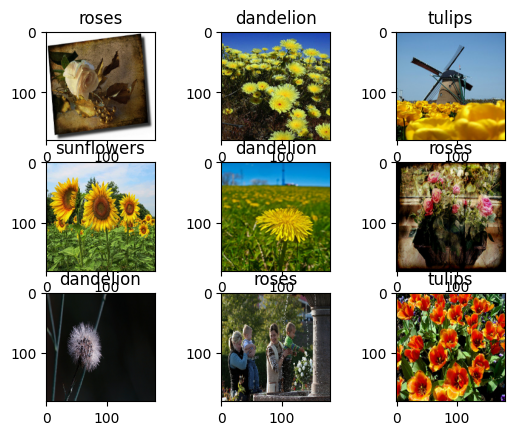

In [ ]:
class_names = train_ds.class_names
#冒頭にて説明した通り、['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']種類の画像がdefaultにて入ってる

import matplotlib.pyplot as plt
#plt.figure(figsize=(10, 10)) mini文字表示が嫌ならadd

for images, labels in train_ds.take(1):
#images, labelsの順番が大事、別にimgsでもlblsでも良いけど
#tf.keras.preprocessing.image_dataset_from_directory()した時点でby default 1st elementはimage情報、2nd elementはlabel情報と決まってる
#batch_size 32に設定したからtake(1)したら、32個画像入ってるから、range(9)とか出来ちゃう
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    #plotとsubplot違い: plotはいわゆる座標、subplotはいわゆるgrid (何row何column) (画像3列3行的な)
    #最初の2つの引数は3*3gridにて画像を配列して表示する指定
    #pythonコードfor i in range(9)にて0~8のvalue入る
    #but matplotlib's subplot functionではvalueは0からではなく1からstart、さらに1個ずつby orderに表示していく
    #だからi+1 (1つ目のimage情報はignoreしてない)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

    #plt.axis("off") #axis消したければ

In [ ]:
#one hot encodingがmachine learningの基本だから、one hot encodingにconvertする
#普通の数字だと、['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']は[0, 1, 2, 3, 4]で表される
#one hot encodingだと、'daisy'は[1, 0, 0, 0, 0]で表される
def one_hot_encode(image, label): #順番関係あり、image, labelの2nd elementがlabel情報 by default
    label = tf.one_hot(label, 5)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

**Train the Model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.applications import ResNet50


# Load the pre-trained ResNet50 model
# ResNet50 modelはGANsでもなくCNNsの画像classification model
pretrained_model = ResNet50(include_top=False,
                            pooling='avg',
                            weights='imagenet')

# Make sure the layers of the pre-trained model are not trainable
#なぜならpretrained_modelは既にlarge dataにより質高いtrain終わってるから
#今回は下記でaddされたnew layerのtrainに集中したい
#だからpretrained_modelを一旦freezeさせる
for layer in pretrained_model.layers:
    layer.trainable = False


input_tensor = Input(shape=(180, 180, 3))

x = pretrained_model(input_tensor)

# Flatten the output of the pre-trained model
x = Flatten()(x)

# Add a dense layer with 512 units and a ReLU activation
x = Dense(512, activation='relu')(x)

# Add the final output layer with 5 units (for the 5 classes) and a softmax activation
output_tensor = Dense(5, activation='softmax')(x)

# Create the model
resnet_model = Model(input_tensor, output_tensor)


resnet_model.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
__________________________________________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=10

#model fitちゃんとやってます
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 27s 146ms/step - loss: 0.6888 - accuracy: 0.7824 - val_loss: 0.4051 - val_accuracy: 0.8597
Epoch 2/10
92/92 [==============================] - 10s 100ms/step - loss: 0.2696 - accuracy: 0.9057 - val_loss: 0.3688 - val_accuracy: 0.8692
Epoch 3/10
92/92 [==============================] - 10s 99ms/step - loss: 0.1763 - accuracy: 0.9428 - val_loss: 0.4563 - val_accuracy: 0.8569
Epoch 4/10
92/92 [==============================] - 10s 109ms/step - loss: 0.0935 - accuracy: 0.9693 - val_loss: 0.4519 - val_accuracy: 0.8651
Epoch 5/10
92/92 [==============================] - 10s 107ms/step - loss: 0.0789 - accuracy: 0.9748 - val_loss: 0.4363 - val_accuracy: 0.8624
Epoch 6/10
92/92 [==============================] - 10s 100ms/step - loss: 0.0359 - accuracy: 0.9911 - val_loss: 0.3965 - val_accuracy: 0.8801
Epoch 7/10
92/92 [==============================] - 9s 92ms/step - loss: 0.0164 - accuracy: 0.9980 - val_loss: 0.4159 - val_accuracy: 0.8910
Ep

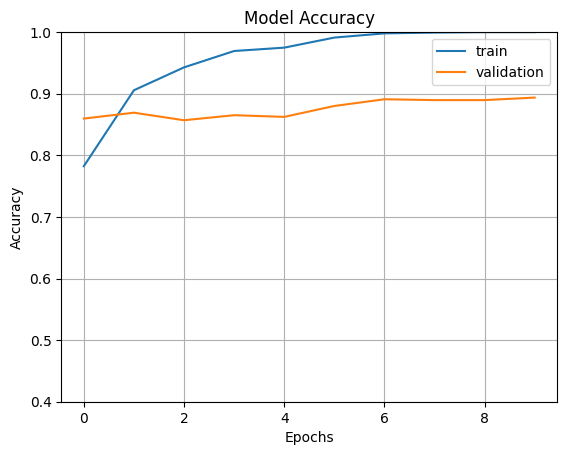

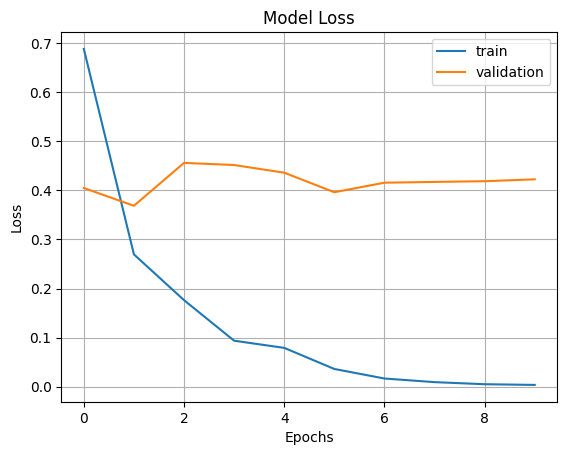

In [ ]:
###accuracy###
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

###loss###
#unseenであるvalidation dataにおいてそこまでperformance発揮できてないから、trainin rate変えるor epoch数増やすetc
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

**Making Predictions**

In [ ]:
#####random image version#####
import cv2 #Python Library mainly used for image and video processing
image_path = "/content/images-1.jpg"
image = cv2.imread(image_path)  # Read the image using OpenCV
image_resized = cv2.resize(image, (img_height, img_width))  # Resize the image
image_expanded = np.expand_dims(image_resized, axis=0)


pred = resnet_model.predict(image_expanded)
print(pred)



output_class=class_names[np.argmax(pred)]
#np.argmax(pred)に関して
#unseen画像ぶち込んで、以下のように、そのunseenがdaisyかdandelionかrosesかsunflowersかtulipsであるそれぞれ確率が出る
#[0.1, 0.2, 0.05, 0.6, 0.05]
#その中で最も確率高いものを、回答に採用という話(今回はindex3の0.6)みたいな

print("The predicted class is", output_class)

1/1 [==============================] - 0s 25ms/step
[[0.27133837 0.6041196  0.0285005  0.04560443 0.05043707]]
The predicted class is dandelion
